# HANC with a Welfare State

In part I the model is set up and tested. In part II the questions are answered.

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    
- 8. [Test transition path](#toc8_)    
- 9. [Find transition path](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize
from scipy.optimize import minimize_scalar
import copy
from copy import deepcopy

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [ ]:
# If new_output = True, all figures and tables will be exported
new_output = False

In [ ]:
model = HANCWelfareModelClass(name='baseline')

par = model.par
ss = model.ss
sol = model.sol
path = model.path

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [ ]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.S = 0.0
ss.Chi = 0.1
ss.G = 0.4

model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)


In [ ]:
par.Chi_ = 0.0
par.G_ = 0.0
model.find_ss(do_print=True)


In [ ]:
def print_ss(model):
    print(f'Steady state values:')
    for varname in model.varlist:
        print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')
print_ss(model)

In [ ]:
model.test_path(in_place=True) 

In [ ]:
model.compute_jacs(do_print=True)

In [ ]:
model.find_transition_path(shocks=[],do_print=True)

# Question A Stationary Equalibrium without gov 

### A 1 Steady state values

In [ ]:
par.G_ = 0.0
par.Chi_ = 0.0
model.find_ss(do_print=False)
print_ss()

In [ ]:
def table_ss(new_output = new_output):
    
    if new_output == True:
        print('exporting')
        with open('tables/table_ss.tex', 'w') as file:
            file.write("\\begin{tabular}{l r}\n")
            file.write("\\hline\n")
            file.write("Variable  & Value \\\\\n")
            file.write("\\hline\n")
            for varname in model.varlist:
                file.write(f'{varname} & {ss.__dict__[varname]:.2f} \\\\\n')
            file.write("\\hline\n")
            file.write("\\end{tabular}\n")
    else:
        print('not exported')

table_ss()

In [ ]:
# Assuming model.varlist and ss.__dict__ are defined

def table_ss(model, new_output = new_output):
    data = {varname: [f'{model.ss.__dict__[varname]:.3f}'] for varname in model.varlist}
    df = pd.DataFrame(data).T  # Transpose to get variables as rows
    df.columns = ['Value']
    df.index.name = 'Variable'

    return df

# Example usage
df = table_ss(model)


if new_output:
    print('exporting')

        # Exporting to LaTeX
    latex_table = df.to_latex()
    with open('tables/table_ss.tex', 'w') as file:
        file.write(latex_table)
else:
    print('not exported')
    print(df)

In [ ]:
new_output = False

### 1.2 Policy functions

In [ ]:
def plot_policy(new_output= new_output):

    i_fix = 0

    fig = plt.figure(figsize=(18,4),dpi=100)
    a_max = 100

    # a. consumption
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,1)
    ax.set_title(f'consumption')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,2)
    ax.set_title(f'saving')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings, $a_{t}$')

    # c. labor supply
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,3,3)
    ax.set_title(f'labor_supply')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('labor supply, $n_{t}$')
    fig.tight_layout()

    if new_output == True:
        print('Exporting')
        plt.savefig('figs/policy_functions.png',dpi=200)
    
    else:
        print('Not exporting')
        plt.show()

plot_policy()


### 1.3 Distribution in ss 

In [ ]:
def plot_cdf(new_output = new_output):

    fig = plt.figure(figsize=(12,4),dpi=100)
    # a. income
    ax = fig.add_subplot(1,2,1)
    ax.set_title('productivity')

    y = np.cumsum(np.sum(ss.D,axis=(0,2)))
    ax.plot(par.z_grid,y/y[-1])

    ax.set_xlabel('productivity, $z_{t}$')
    ax.set_ylabel('CDF')

    # b. assets
    ax = fig.add_subplot(1,2,2)
    ax.set_title('savings')
    y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
            
    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')

    #save figure
    if new_output == True:
        print('Exporting')
        fig.savefig('figs/distribution.png', bbox_inches='tight')
    
    else:
        print('Not exporting')
        plt.show()

plot_cdf()


### 1.4 Expected discounted utility

In [ ]:

def plot_utility(new_output = new_output):

    model.test_path(in_place=True)

    #Ploting the accumulation discounted utility
    par.T = 500
    time_ = [1, 10, 20, 30, 40, 50,  100, 150, 200, 250, 300, 350, 400, 450, 500]



    time_past = []
    disc_utility = []
    for i in time_:
        par.T = i 
        time_past.append(i)
        U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
        disc_utility.append(U)

    print(f'Utility: {disc_utility[-0]:.4f}')

    #figure 
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(time_past, disc_utility, label='Discounted Utility')
    ax.set_xlabel('Time')
    ax.set_ylabel('Utility')
    ax.legend()

    # save figure
    if new_output == True:
        print('Exported')
        fig.savefig('figs/disc_utility.png', bbox_inches='tight')

    else:
        print('Not exported')
        plt.show()

plot_utility()

# B. Optimal welfare policies 1 (no transfers)

### 2.1 Defining new functions

In [ ]:
# New objetctiv function 
def u_gov(x, model):

    """ss discounted sum of utility  given government level"""

    par = model.par
    ss = model.ss
    path = model.path

    par.G_ = x
    model.find_ss(do_print=False)

    model.test_path(in_place=False) 
    model.compute_jacs(do_print=False)
    model.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return U

def obj_gov(x, model):

    """Objective function with government as the choice variable"""

    return - u_gov(x, model)

#testing
u_gov(0.1, model)

### 2.2 Function for calculations

In [ ]:
# Optimize the objective function within the specified range
#par.Chi_ = 0.0

#result = minimize_scalar( obj_gov, bounds=(0.33, 0.5), method='bounded', args=(model))
#obj_gov(result.x, model)

# Print the optimization result
#print(f"Optimal value of x: { result.x}, given Chi = {ss.Chi}")
#print(f"Optimal objective function value: {- result.fun}")
#print(f"G/Y at the optimal level of G : {ss.G/ss.Y}")

### Calculations

In [ ]:
# A. Function 
def calc_chi(chi, model, lists = False):

    # i. Input 
    par.Chi_ = chi

    # ii. Minimizing
    result = minimize_scalar(obj_gov, bounds=(0.36, 0.475), method='bounded', args=(model))

    # iii. Rerunning
    obj_gov(result.x, model)

    Chi_val = ss.Chi
    Gov_val = result.x
    U_val = -result.fun
    Y_G_relatio = ss.G/ss.Y
    Gamma_Y = ss.Gamma_Y


    # iv. Dictionary for resultsis (Optimum values )
    result_dict = {
        'Chi_val': Chi_val,
        'Gov_opt': Gov_val,
        'Gamma_Y': Gamma_Y,
        'U_opt': U_val,
        'Y_G_relatio': Y_G_relatio,
    }  

    # iv. List of U and Gov values for plotting 
    if lists == True:

        g_values = [0.36, 0.39, 0.4, 0.42, 0.45, 0.475]
        u_values = [u_gov(x, model) for x in g_values]
        
        result_dict['g_values'] = g_values
        result_dict['u_values'] = u_values


    return result_dict

# B Caluclation 

#i. Empty dictionary 
chi_results = {}
res_save = {}

#Function to add the results to the dictionary
#def tab_(chi):
#   chi_results[str(chi)] = calc_chi(chi)


# ii. Values to add
#chi_values = [-0.35, -0.2, -0.3, -0.25, -0.2, -0.22, -0.15, -0.1, -0.05, 0.0, 0.05]  # List of chi values to compute

table_val = ['Chi_val', 'Gov_opt','Gamma_Y', 'U_opt', 'Y_G_relatio']


#tab_(chi_values[:])

# iii. Calling the function 
#for chi in chi_values:
#    chi_results[str(chi)] = calc_chi(chi, model, lists=True)


### Results

In [ ]:
#chi_results[str(0.0)] = calc_chi(0.0, model, lists=True)
res_save['Model b'] = calc_chi(0.0, model, lists=True)


In [ ]:
print(f'Optimal values \n')
for i in table_val:
    print(i)
    print(chi_results['0.0'][i])

### Figure

In [ ]:
# Assuming chi_results is defined and populated as before
def plot_chi(new_output= new_output, chi0 = True):

    fig = plt.figure(figsize=(7, 7), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('')

    opt_gov_values = []
    opt_u_values = []


    if chi0:
        i = '0.0'
        ax.plot(chi_results[i]['g_values'], chi_results[i]['u_values'])
        ax.scatter(chi_results[i]['Gov_opt'], chi_results[i]['U_opt'], marker='o', label=f'chi = {i}, optimal utility = {chi_results[i]["U_opt"]:.2f}', color='black')
        opt_gov_values.append(chi_results[i]['Gov_opt'])
        opt_u_values.append(chi_results[i]['U_opt'])

    else:
        for i in chi_results.keys():
            ax.plot(chi_results[i]['g_values'], chi_results[i]['u_values'])
            ax.scatter(chi_results[i]['Gov_opt'], chi_results[i]['U_opt'], marker='o', label=f'chi = {i}, optimal utility = {chi_results[i]["U_opt"]:.2f}')
            opt_gov_values.append(chi_results[i]['Gov_opt'])
            opt_u_values.append(chi_results[i]['U_opt'])

    # Plotting the line connecting optimal points
    ax.plot(opt_gov_values, opt_u_values, color='grey', linestyle='--', marker='')

    ax.set_xlabel('Government Production')
    ax.set_ylabel('Utility')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if new_output == True:
        if chi0:
            fig.savefig('figs/chi0_gov.png', bbox_inches='tight')
        else: 
            fig.savefig('figs/chi_gov_all.png', bbox_inches='tight')
    else:
        plt.show()

plot_chi()



# 3. Find optimal welfare policies II (with transfers)

**C.1: New objective function**  

In [ ]:
# New objetctiv function 
def u_gov_chi(x, model):
    """ss discounted sum of utility  given government level"""
    par.G_ = x[0]
    par.Chi_ = x[1]

    model.find_ss(do_print=False)

    #model.find_transition_path(shocks=[],do_print=False)
    model.test_path(in_place=False) 
    model.compute_jacs(do_print=False)
    model.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return  U

def obj_gov_chi(x, model):
    return - u_gov_chi(x, model)

**C.2: Optimal Governement production and transfers)**

In [ ]:
#Initial quess
x0 = [0.4, -0.2]

# Reruning 
result = optimize.minimize(obj_gov_chi, x0, method='Nelder-Mead', args=(model))

#Rerun 
u_gov_chi(result.x, model)


In [ ]:
#Additional Calculations
par.G_ = result.x[0]

chi_results[str(result.x[1])] = calc_chi(result.x[1], model, lists=True)

chi_results



**C.3: Additional caluclaitons for plotting (Slow)**

In [ ]:
chi_values = [-0.35, -0.2, -0.3, -0.25, -0.2, -0.22, -0.15, -0.1, -0.05, 0.0, 0.05]  # List of chi values to compute

table_val = ['Chi_val', 'Gov_opt','Gamma_Y', 'U_opt', 'Y_G_relatio']

opt_u_values = []



# Additional Chi values for plotting 
for chi in chi_values:
    chi_results[str(chi)] = calc_chi(chi, model, lists=True)

for i in chi_values:
        opt_u_values.append(chi_results[str(i)]['U_opt'])


**C.4: Ploting max utility against transfer($\chi$)** 

In [ ]:
def plot_chi_u(new_output=new_output):
    fig = plt.figure(figsize=(7, 7), dpi=100)
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(chi_values, opt_u_values )
    ax.set_ylabel('Utility')
    ax.set_xlabel('Transfers ($\chi$)')
    ax.axvline(x=0, color='grey', linestyle='--')  # 'r' is for red color, '--' for dashed line
    if new_output:
        fig.savefig('figs/chi_utility.png')
    else:
        fig.show
        print('Not exporting')
plot_chi_u()

**C.5: Ploting gonvernment production and utility for $\chi$ values**

In [ ]:
plot_chi(chi0 = False)

# D Increased TFP 

4.1 Soling the model for increaed TFP - more productive private sector. Solving using optimal chi and G from 3.1

In [ ]:
#Copy the steady state values
ini_ = model.ss.__dict__.copy()

model2 = deepcopy(model)
model2.par.G_ = 0.4653
model2.par.Chi_ = -0.2477

model2.par.Gamma_G_ = 1.0
model2.par.Gamma_Y_ = 1.1
model2.find_ss()

In [ ]:
# New objetctiv function 
def u_gov_chi(x, model):
    """ss discounted sum of utility  given government level"""

    par = model.par
    ss = model.ss
    path = model.path

    par.G_ = x[0]
    par.Chi_ = x[1]

    model.find_ss(do_print=False)

    #model.find_transition_path(shocks=[],do_print=False)
    model.test_path(in_place=False) 
    model.compute_jacs(do_print=False)
    model.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return  U

def obj_gov_chi(x, model):
    return - u_gov_chi(x, model)


In [ ]:
#Initial quess
x0 = [0.4653, -0.2477]

# Reruning 
result_2 = optimize.minimize(obj_gov_chi, x0, method='Nelder-Mead', args=(model2))

#Rerun 
u_gov_chi(result_2.x, model2)

In [ ]:
res_ss = {}

In [ ]:
res_ss['model2'] = table_ss(model2)

In [ ]:
res_ss

In [ ]:
model2.par.G_ = result_2.x[0]
res_save['Model d'] = calc_chi(result_2.x[0], model, lists=True)

In [ ]:
model.G = result.x[0]
#ch_opt = str(np.round(result.x[1], 2))
#ch_opt

calc_chi(result.x[0], model, lists=True)

In [ ]:

df = pd.DataFrame.from_dict(chi_results, orient='index')

In [ ]:
selected_columns = ['Chi_val', 'Gov_opt', 'Gamma_Y', 'U_opt', 'Y_G_relatio']
df_selected = df[selected_columns]

# Round all numeric values to 3 decimal places
df_selected = df_selected.round(3)

# Export to LaTeX
latex_table = df_selected.to_latex(index=False)

print(latex_table)

In [ ]:

#chi_values

opt_u_values = []

for i in chi_values:
        opt_u_values.append(chi_results[i][opt_u_values])
print(opt_u_values)

chi_values 


opt_gov_values.append(chi_results[i]['Gov_opt'])
opt_u_values.append(chi_results[i]['U_opt'])



fig = plt.figure(figsize=(7, 7), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('')

ax.plot()



        i = '0.0'
        ax.plot(chi_results[i]['g_values'], chi_results[i]['u_values'])
        ax.scatter(chi_results[i]['Gov_opt'], chi_results[i]['U_opt'], marker='o', label=f'chi = {i}, optimal utility = {chi_results[i]["U_opt"]:.2f}', color='black')
        opt_gov_values.append(chi_results[i]['Gov_opt'])
        opt_u_values.append(chi_results[i]['U_opt'])

In [ ]:
# IKKE HER 
table_val = ['Chi_val', 'Gov_opt','Gamma_Y', 'U_opt', 'Y_G_relatio']



with open('tables/results.tex', 'w') as file:
    file.write("\\begin{tabular}{c c c c}\n")
    file.write("\\hline\n")
    file.write("Chi & Government & U & Y/G \\\\\n")
    file.write("\\hline\n")
    for i in chi_results.keys():
        file.write(f"{chi_results[f'{i}']['Chi_val']} & {chi_results[f'{i}']['Gov_opt']:.3f} & {chi_results[f'{i}']['U_opt']:.3f} & {chi_results[f'{i}']['Y_G_relatio']:.3f} \\\\\n")
    file.write("\\hline\n")
    file.write("\\end{tabular}\n")
    

Values of U given G and Chi


### 3.1 Table with chi and --- 

In [ ]:
# Doing Q 2 for more chi values 
# ii. Values to add
#chi_values = [-0.35, -0.2, -0.3, -0.25, -0.2, -0.22, -0.15, -0.1, -0.05, 0.0, 0.05]  # List of chi values to compute


#tab_(chi_values[:])

# iii. Calling the function 
#for chi in chi_values:
#    chi_results[str(chi)] = calc_chi(chi, model, lists=True)

In [ ]:
table_val = ['Chi_val', 'Gov_opt','Gamma_Y', 'U_opt', 'Y_G_relatio']

with open('tables/results.tex', 'w') as file:
    file.write("\\begin{tabular}{c c c c}\n")
    file.write("\\hline\n")
    file.write("Chi & Government & U & Y/G \\\\\n")
    file.write("\\hline\n")
    for i in chi_results.keys():
        file.write(f"{chi_results[f'{i}']['Chi_val']} & {chi_results[f'{i}']['Gov_opt']:.3f} & {chi_results[f'{i}']['U_opt']:.3f} & {chi_results[f'{i}']['Y_G_relatio']:.3f} \\\\\n")
    file.write("\\hline\n")
    file.write("\\end{tabular}\n")
    

In [ ]:
# Assuming chi_results is defined and populated as before
def old(new_output= new_output):

    fig = plt.figure(figsize=(7, 7), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('')

    opt_gov_values = []
    opt_u_values = []

    for i in chi_results.keys():
        ax.plot(chi_results[i]['g_values'], chi_results[i]['u_values'])
        ax.scatter(chi_results[i]['Gov_opt'], chi_results[i]['U_opt'], marker='o', label=f'chi = {i}, optimal utility = {chi_results[i]["U_opt"]:.2f}')
        opt_gov_values.append(chi_results[i]['Gov_opt'])
        opt_u_values.append(chi_results[i]['U_opt'])

    # Plotting the line connecting optimal points
    ax.plot(opt_gov_values, opt_u_values, color='grey', linestyle='--', marker='')

    ax.set_xlabel('Government Production')
    ax.set_ylabel('Utility')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if new_output == True:
        fig.savefig('figs/chi_gov.png', bbox_inches='tight')
    else:
        plt.show()

#plot_chi()

#*** Add a gradual color schemme

### Optimising

In [ ]:
print(f'Optimal values \nx: { result.x[0]} \nChi = {result.x[1]}  \nUtility = {-result.fun} \nG = {ss.G} \nG to Y ratio = ' )


### Printing 

 
 Løsning: 
 
 message: Solution found.
 success: True
  status: 0
     fun: 136.88928464017815
       x: -0.21819642050038354
     nit: 8
    nfev: 8

In [ ]:
# Optimize the objective function within the specified range
par.Chi_ = results.x

result_2 = minimize_scalar( obj_gov, bounds=(0.43, 0.46), method='bounded')

# Print the optimization result
print(f"Optimal value of x: { result_2.x}, given Chi = {ss.Chi}")
print(f"Optimal objective function value: {- result_2.fun}")
print(f"G/Y at the optimal level of G : {ss.G/ss.Y}")
print(f'G = {ss.G}')

### 3.2 Plotting the utility for given values of chi and G 

### 3.3 plot of \chi and G (3D)

New optimal chi and G:

In [ ]:
x0 = [0.4, -0.2]
result_model2 = optimize.minimize(u_gov_chi, x0, method='Nelder-Mead', args=(model_))
u_gov_chi(result_model2.x)

In [ ]:
calc_chi

4.2 Printing the new values of the steady state:

In [ ]:
# printing 
def print_ss(model):
    print(f'Steady state values:')
    for varname in model.varlist:
        print(f'{varname:15s}: {model.ss.__dict__[varname]:.4f}')
print_ss(model_)

### Adding to the results table 


In [ ]:
x0 = [0.4, -0.2]
result = optimize.minimize(u_gov_chi, x0, method='Nelder-Mead', args=(model))

In [ ]:

model_.compute_jacs(do_print=False)
model_.find_transition_path(shocks=[],do_print=False, ini=ini_)
model_.show_IRFs( varnames= ['Y', 'G', 'U_hh'])


In [ ]:
#plt.plot(model_.path.__dict__['S'][:100]/model_.path.__dict__['Y'][:100])
#plt.plot(model_.path.__dict__['Y'][:100])

plt.plot(path.__dict__['U_hh'][:10])



#U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])


# Start

In [ ]:
# New objetctiv function 
def u_gov_chi(x, model):
    """ss discounted sum of utility  given government level"""

    par = model.par
    ss = model.ss
    path = model.path

    par.G_ = x[0]
    par.Chi_ = x[1]

    model.find_ss(do_print=False)


    model.test_path(in_place=False) 
    model.compute_jacs(do_print=False)
    model.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return  U

def obj_gov_chi(x, model):
    return - u_gov_chi(x, model)


# Stop 

In [ ]:
# New objetctiv function 
def u_gov_chi_model2(x, model_in):
    """ss discounted sum of utility  given government level"""
    par = model_in.par
    ss = model_in.ss
    path = model_in.path

    model_in.par.G_ = x[0]
    model_in.par.Chi_ = x[1]

    model_in.find_ss(do_print=False)

    #model.find_transition_path(shocks=[],do_print=False)
    model_in.test_path(in_place=False) 
    model_in.compute_jacs(do_print=False)
    model_in.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return - U

In [ ]:
x0 =[0.4, -0.2]

result3 = optimize.minimize(u_gov_chi_model2, x0, method='Nelder-Mead', args=model2)
u_gov_chi_model2(result3.x, model2)


# Print the optimization result
print(f"Optimal value of x: { result3.x[0]}, given Chi = {ss.Chi}, {result3.x[1]}")
print(f"Optimal objective function value: {- result3.fun}")
print(f"G/Y at the optimal level of G : {ss.G/ss.Y}")
print(f'G = {ss.G}')

In [ ]:
table_ss(model2)

In [ ]:
# New objetctiv function 
def u_gov_chi_model2(x):
    """ss discounted sum of utility  given government level"""
    par = model2.par
    ss = model2.ss
    path = model2.path

    model2.par.G_ = x[0]
    model2.par.Chi_ = x[1]

    model2.find_ss(do_print=False)

    #model.find_transition_path(shocks=[],do_print=False)
    model2.test_path(in_place=False) 
    model2.compute_jacs(do_print=False)
    model2.find_transition_path(shocks=[],do_print=False)

    U =np.sum([par.beta**t * np.sum(path.u[t]*path.D[t]/np.sum(path.D[t])) for t in range(par.T)])
    
    return - U

In [140]:

#chi_results[str(0.0)] = calc_chi(0.0, model, lists=True)

res_save['Model d'] = calc_chi(0.0, model, lists=True)

shocks: G L_G Gamma_Y Gamma_G 
unknowns: K L_Y 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 tau              0.0e+00
 wt               0.0e+00
 Chi              0.0e+00
 S                0.0e+00
hh
 A_hh             8.8e-10
 C_hh             2.3e-11
 ELL_hh           9.8e-11
 L_hh             7.9e-11
 INC_hh           4.8e-12
 U_hh             2.1e-10
blocks.market_clearing
 L                7.9e-11
 I                1.1e-16
 clearing_A       5.1e-09 [target]
 clearing_L       7.9e-11
 clearing_Y       2.3e-11
 clearing_G       8.7e-10 [target]
shocks: G L_G Gamma_Y Gamma_G 
unknowns: K L_Y 

blocks.production_firm
 rK               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
blocks.government
 tau              0.0e+00
 wt               0.0e+00
 Chi      

NameError: name 'res_save' is not defined

In [ ]:
table_ss(model2)

In [127]:
# a. define shock
dG = np.zeros(par.T)
dG[:4] = 0.01*ss.G
dL_G = np.np.zeros(par.T)
dL_G[:4] = 0.res_save['Model c']

shocks = {'dG':dG} # note the 'd' for difference (in absolute terms)


shocks = []

model2.find_transition_path(shocks=[], ini=ini_)

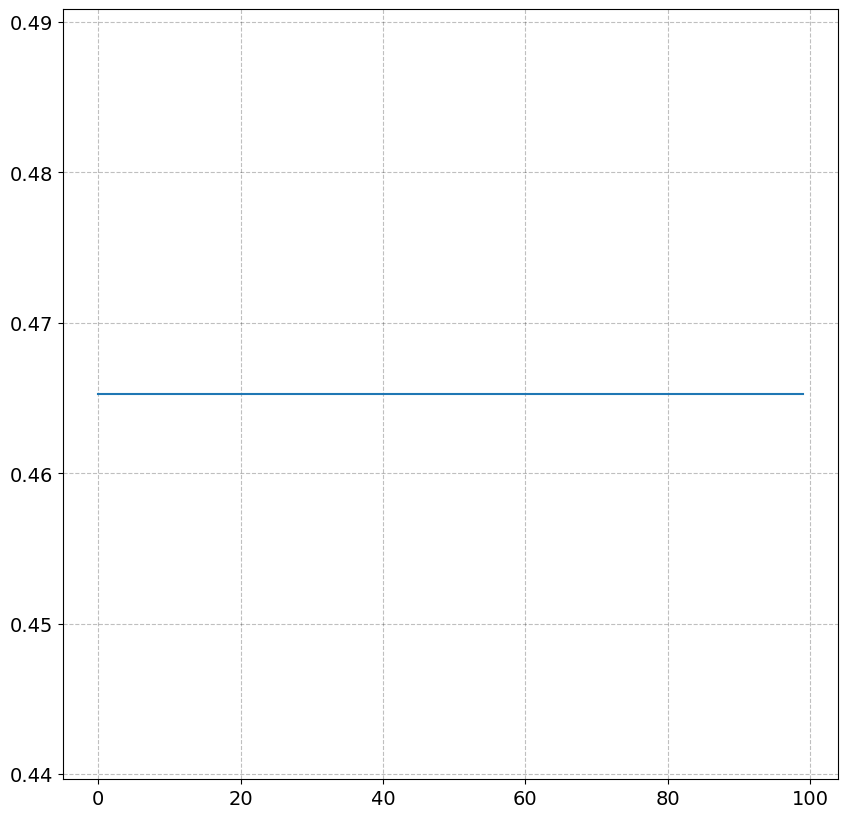

In [136]:
fig = plt.figure(figsize=(10, 10), dpi=100)


ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(model2.path.G[:100])
#ax1.plot(model2.path.U_hh[:100])
#ax1.plot(model2.path.G[:100]/model2.path.Y[:100])



In [ ]:


model_.compute_jacs(do_print=False)
model_.find_transition_path(shocks=[],do_print=False, ini=ini_)
model_.show_IRFs( varnames= ['Y', 'G', 'U_hh'])

# STOP 

In [ ]:
# Error  RuntimeWarning: invalid value encountered in double_scalars
# Create the figure and subplots
fig = plt.figure(figsize=(10, 10), dpi=100)

#
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Productivity')


g_values = np.linspace(0.3, 0.5, 20)
u_values = [u_gov(x) for x in g_values]


# Plot the objective function
ax.plot(g_values, u_values, label='Objective Function')
ax.set_xlabel('Government production')
ax.set_ylabel('Discounted expected utility')
ax.set_title('Plot of Objective Function')
ax.grid(True)
ax.legend()

# Plot the minimum point
ax.scatter(result.x, u_gov(result.x), color='red', label='Optimal government consumption', marker='o')
ax.legend()

# Save figure
fig.savefig('figs/fig_optimal_G.png', bbox_inches='tight')

# Show the figure
plt.show()


## Question 3

In [ ]:
# Optimize the objective function within the specified range
par.Chi_ss = 0.05

result = minimize_scalar( obj_gov, bounds=(0.375, 0.45), method='bounded')

# Print the optimization result
print(f"Optimal value of x: {- result.x}, given Chi = {ss.Chi}")
print(f"Optimal objective function value: {- result.fun}")

# G/Y in the steady state
# PROBLEM - G in the steady state: 1.22 skal være 0.41493
print(f"G/Y in the steady state: {ss.G/ss.Y}")
print(f"L_G in the steady state: {ss.L_G}")
print(f"G in the steady state: {ss.Y}")
print(f"Y in the steady state: {ss.Gamma_G}")
print(f'S in the steady state: {ss.S}')
print(f'Chi in the steady state: {ss.Chi}')
print(f'U_hh in the steady state: {ss.U_hh}')
print(f'G_ss in the steady state: {par.G_ss}')

In [ ]:
# Error  RuntimeWarning: invalid value encountered in double_scalars
# Create the figure and subplots
fig = plt.figure(figsize=(10, 10), dpi=100)

#
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Productivity')

g_values = np.linspace(0.3, 0.5, 10)
u_values = [u_gov(x) for x in g_values]


# Plot the objective function
ax.plot(g_values, u_values, label='Objective Function')
ax.set_xlabel('Government production')
ax.set_ylabel('Discounted expected utility')
ax.set_title('Plot of Objective Function')
ax.grid(True)
ax.legend()

# Plot the minimum point
ax.scatter(result.x, u_gov(result.x), color='red', label='Optimal government consumption', marker='o')
ax.legend()

# Save figure
#fig.savefig(f'figs/fig_optimal_G_{ss.Chi}.png', bbox_inches='tight')

# Show the figure
plt.show()


In [ ]:
# Define Chi and G values more densely for a smooth surface
#Chi_values = np.linspace(0.0, 0.1, 2)  # Increased number of points for smoothness
#G_values = np.linspace(0.4, 0.4, 2)


# Create a meshgrid
#Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

print(f'Chi_grid: {Chi_grid}')
print(f'Chi_grid: {G_grid}')
print(f'U_grid: {U_grid}')

In [ ]:
# Define Chi and G values more densely for a smooth surface
Chi_values = np.linspace(0.0, 0.1, 2)  # Increased number of points for smoothness
G_values = np.linspace(0.4, 0.4, 2)


# Create a meshgrid
Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

# Initialize an empty grid for U values
U_grid = np.zeros_like(Chi_grid)

# Compute U values for each combination of Chi and G
for i in range(Chi_grid.shape[0]):
    for j in range(G_grid.shape[1]):

        par.Chi_ss = Chi_grid[i, j]
        par.G_ss = G_grid[i, j]
        model.find_ss(do_print=False)
        U_grid[i, j] = ss.U_hh

In [ ]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot with color based on U values
surface = ax.plot_surface(Chi_grid, G_grid, U_grid, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(surface)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()

# 3. Optimal welfare policies 2 (with transfers)

In [ ]:

# Define Chi and G values more densely for a smooth surface
#Chi_values = np.linspace(0.0, 0.1, 5)  # Increased number of points for smoothness
#G_values = np.linspace(0.3, 0.5, 5)

# Create a meshgrid
#Chi_grid, G_grid = np.meshgrid(Chi_values, G_values)

# Initialize an empty grid for U values
#U_grid = np.zeros_like(Chi_grid)

# Compute U values for each combination of Chi and G
#for i in range(Chi_grid.shape[0]):
#    for j in range(G_grid.shape[1]):
#        par.Chi_ = Chi_grid[i, j]
#        par.G_ = G_grid[i, j]
#        model.find_ss(do_print=False)
#        U_grid[i, j] = ss.U_hh

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot with color based on U values
surface = ax.plot_surface(Chi_grid, G_grid, U_grid, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(surface)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# ... [your code to compute Chi_list, G_list, U_list] ...

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on U values
scatter = ax.scatter(Chi_list, G_list, U_list, c=U_list, cmap='viridis')

# Adding a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('U values')

# Labeling axes
ax.set_xlabel('Chi')
ax.set_ylabel('G')
ax.set_zlabel('U')

# Show plot
plt.show()